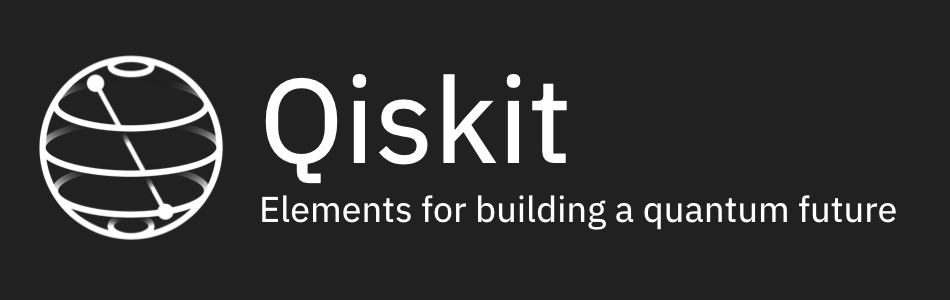

# _*Qiskit Aqua: Generating Ising Hamiltonians from optimization models with DOcplex*_

The latest version of this notebook is available on https://github.com/Qiskit/qiskit-tutorial.

***
### Contributors
Atsushi Matsuo<sup>[1]</sup>, Takashi Imamichi<sup>[1]</sup>, Marco Pistoia<sup>[1]</sup>, Stephen Wood<sup>[1]</sup>
### Affiliation
- <sup>[1]</sup>IBMQ

## Introduction
There has been a growing interest in using quantum computers to find solutions of combinatorial problems. A heuristic approach for finding solutions of combinatorial problems on quantum computers is the quantum variational approach, such as the Variational Quantum 
Eigensolver (VQE) algorithm (see https://arxiv.org/abs/1802.00171 and the Quantum Approximate Optimization Algorithm (QAOA) (see https://arxiv.org/abs/1411.4028). In order to use a quantum variational approach on quantum computers, first, we need to map a combinatorial problem to an Ising Hamiltonian. However, Ising Hamiltonians are complicated and unintuitive. Mapping a combinatorial problem to Ising Hamiltonians can be a difficult and time-consuming task, requiring specialized knowledge.

In this tutorial, we introduce a translator to automatically generate Ising Hamiltonians from classical optimization models. We will explain about classical optimization models later. The translator dramatically simplifies the task of designing and implementing quantum-computing-based solutions, for optimization problems, by automatically generating Ising Hamiltonians for different optimization problems. With the translator, all a user has to do is to write optimization models using DOcplex (see https://cdn.rawgit.com/IBMDecisionOptimization/docplex-doc/master/docs/index.html). DOcplex is a python library for optimization problems.
Then the translator will automatically generate Ising Hamiltonians from the models. Optimization models are short and intuitive. It is much easier to write optimization models compared to writing Ising Hamiltonians manually. 

The quantum variational approach works with the translator in Qiskit Aqua as follows:
1. Write an optimization model of the formulation with DOcplex.
2. Call the translator to transform the model into an Ising Hamiltonian.
3. Solve the problem with variational algorithms such as VQE and QAOA.


### Details of Optimization Models
The translator supports the generation of an Ising Hamiltonian from the following optimization model elements:
- Binary decision variables. 
- Linear and quadratic terms in objective functions.
- Only equality constraints.  

Input models are validated before transformation. If the model contains elements that are not from the supported set, an error will be raised.

Even though there are restrictions, this type of optimization model can handle optimization problems such as max-cut, traveling salesman etc.
These are typical optimization problems. Examples of the translator being used for Max-Cut and TSP problems can be found in the following tutorial:
- [Qiskit Aqua: Experimenting with Max-Cut problem and Traveling Salesman problem with variational quantum eigensolver](max_cut_and_tsp.ipynb)

### A Usage Example: Maximize the number of variables by taking into account constraints
The following is a toy example of a maximization problem with constraints.

\begin{aligned}
   & \text{maximize}
       & \sum_{i} x_{i}\\
   & \text{subject to}
       & \sum_{i} i * x_{i}=3\\
       & & i \in \{1,2,3,4\} \\
       & & x_i \in \{0,1\}\\
\end{aligned}

In [1]:
from docplex.mp.model import Model

from qiskit import BasicAer
from qiskit.aqua.algorithms import VQE, ExactEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua import QuantumInstance
from qiskit.optimization.ising import docplex
from qiskit.optimization.ising.common import sample_most_likely

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
# set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

### Creating an optimization model of the above problem using DOcplex
An optimization model of the problem with DOcplex is written as follows.  
* First an instance of `Model` is created and variables for the model are defined. 
* Next an objective function is written and passed to the model. The objective function is a function that we would like to minimize (or maximize).
* Finally constraints are added. 

In [2]:
# Create an instance of a model and variables
mdl = Model(name='max_vars')
x = {i: mdl.binary_var(name='x_{0}'.format(i)) for i in range(1,5)}

# Objective function
max_vars_func = mdl.sum(x[i] for i in range(1,5))
mdl.maximize(max_vars_func)

# Constraints
mdl.add_constraint(mdl.sum(i*x[i] for i in range(1,5)) == 3)

print(mdl.export_to_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: max_vars

Maximize
 obj: x_1 + x_2 + x_3 + x_4
Subject To
 c1: x_1 + 2 x_2 + 3 x_3 + 4 x_4 = 3

Bounds
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1
 0 <= x_4 <= 1

Binaries
 x_1 x_2 x_3 x_4
End



### Generate an Ising Hamiltonian from the model using ```docplex.get_operator(mdl)```


In [3]:
qubitOp, offset = docplex.get_operator(mdl)

### Checking that the full Hamiltonian gives the right cost

In [4]:
ee = ExactEigensolver(qubitOp, k=1)
result = ee.run()

print('energy:', result['energy'])
print('objective:', result['energy'] + offset)

x = sample_most_likely(result['eigvecs'][0])
print('solution:', x)

energy: -57.5
objective: -2.0
solution: [1. 1. 0. 0.]


### Running it on quantum computer
We run the optimization routine using a feedback loop with a quantum computer that uses trial functions built with Y single-qubit rotations, $U_\mathrm{single}(\theta) = \prod_{i=1}^n Y(\theta_{i})$, and entangler steps $U_\mathrm{entangler}$.

In [5]:
seed = 10598

spsa = SPSA(max_trials=300)
ry = RY(qubitOp.num_qubits, depth=5, entanglement='linear')
vqe = VQE(qubitOp, ry, spsa)

backend = BasicAer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

result = vqe.run(quantum_instance)

x = sample_most_likely(result['eigvecs'][0])
print('energy:', result['energy'])
print('time:', result['eval_time'])
print('solution objective:', result['energy'] + offset)
print('solution:', x)

energy: -57.12443617208386
time: 7.2084033489227295
solution objective: -1.6244361720838612
solution: [1. 1. 0. 0.]


In [6]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright